# Graphene band structure

This example plots the band structure of graphene, a 2D material. 2D band
structures are not supported natively (yet), so we manually build a custom
path in reciprocal space.

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -11.15665243515                   -0.60    5.9         
  2   -11.16017385524       -2.45       -1.30    1.0    119ms
  3   -11.16039549099       -3.65       -2.33    1.9    139ms
  4   -11.16041670337       -4.67       -3.26    3.0    183ms
  5   -11.16041704521       -6.47       -3.47    3.0    173ms
  6   -11.16041704940       -8.38       -3.64    1.4    120ms
  7   -11.16041705113       -8.76       -3.96    2.0    146ms
  8   -11.16041705137       -9.63       -4.39    2.0    131ms
  9   -11.16041705141      -10.41       -4.80    2.1    145ms
 10   -11.16041705143      -10.71       -5.06    2.4    147ms
 11   -11.16041705144      -10.82       -5.34    2.6    155ms
 12   -11.16041705145      -11.28       -5.64    2.6    177ms
 13   -11.16041705145      -11.66       -6.15    2.9    165ms
Computing bands along kpath:
       Γ -> M -> K -> Γ
Diagonalising Hami

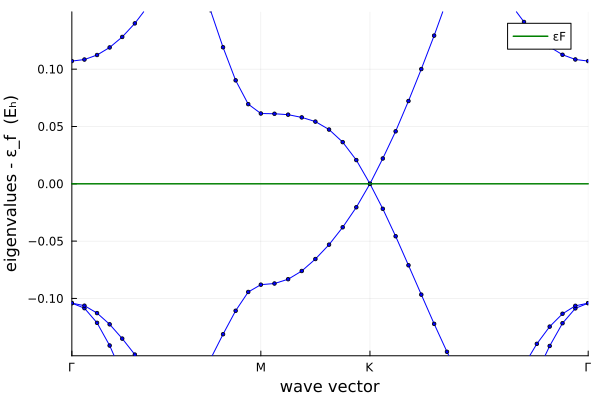

In [1]:
using DFTK
using Unitful
using UnitfulAtomic
using LinearAlgebra
using Plots

# Define the convergence parameters (these should be increased in production)
L = 20  # height of the simulation box
kgrid = [6, 6, 1]
Ecut = 15
temperature = 1e-3

# Define the geometry and pseudopotential
a = 4.66  # lattice constant
a1 = a*[1/2,-sqrt(3)/2, 0]
a2 = a*[1/2, sqrt(3)/2, 0]
a3 = L*[0  , 0        , 1]
lattice = [a1 a2 a3]
C1 = [1/3,-1/3,0.0]  # in reduced coordinates
C2 = -C1
positions = [C1, C2]
C = ElementPsp(:C, psp=load_psp("hgh/pbe/c-q4"))
atoms = [C, C]

# Run SCF
model = model_PBE(lattice, atoms, positions; temperature)
basis = PlaneWaveBasis(model; Ecut, kgrid)
scfres = self_consistent_field(basis)

# Construct 2D path through Brillouin zone
sgnum = 13  # Graphene space group number
kpath = irrfbz_path(model; dim=2, sgnum)
plot_bandstructure(scfres, kpath; kline_density=20)